# Unit 5 - Financial Planning


In [3]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [4]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [5]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [6]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [7]:
# Fetch current BTC price
btc_data = requests.get(btc_url).json()
btc_price = float(btc_data['data']['1']['quotes']['USD']['price'])
# Fetch current ETH price
eth_data = requests.get(eth_url).json()
eth_price = float(eth_data['data']['1027']['quotes']['USD']['price'])
# Compute current value of my crpto
my_btc_value= my_btc * btc_price
my_eth_value= my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $71328.00
The current value of your 5.3 ETH is $9846.23


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [8]:
# Current amount of shares
my_spy = 50
my_agg = 200

In [9]:
# Set Alpaca API key and secret

alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [10]:
# Create the Alpaca API object

alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [12]:
# Format current date as ISO format
today = pd.Timestamp("2021-03-17", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
bond_stock = alpaca.get_barset(
    tickers,
    timeframe,
    start = today,
    end = today
).df
# Preview DataFrame
closing_prices = pd.DataFrame()
closing_prices['SPY'] = bond_stock['SPY']['close']
closing_prices['AGG'] = bond_stock['AGG']['close']
closing_prices.index = closing_prices.index.date
closing_prices

,SPY,AGG
2021-03-17,397.22,113.87


In [13]:
# Pick AGG and SPY close prices

agg_close_price = closing_prices.iloc[0, 1]
spy_close_price = closing_prices.iloc[0, 0]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $113.87
Current SPY closing price: $397.22


In [14]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of share
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $19861.00
The current value of your 200 AGG shares is $22774.00


### Savings Health Analysis

In [15]:
# Set monthly household income
monthly_income = 12000

# Create savings DataFrame
df_savings = {
    "crypto": my_btc_value + my_eth_value,
    "shares": my_spy_value + my_agg_value             
}

# Display savings DataFrame
df_savings = pd.DataFrame.from_dict(df_savings, orient='index')
df_savings.columns = ['amount']
display(df_savings)


,amount
crypto,81174.234
shares,42635.000


<AxesSubplot:ylabel='amount'>

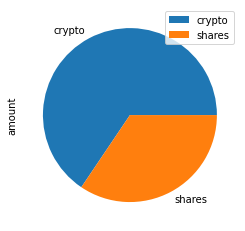

In [16]:
# Plot savings pie chart
df_savings.plot.pie(y='amount')

In [17]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings.iloc[0,0] + df_savings.iloc[1,0]

# Validate saving health
if total_savings > emergency_fund:
    print('Congrats! You have enough money in savings to fulfill your emergency fund.')
elif total_savings == emergency_fund:
    print('Congrats! You have met your savings goal.')
else:
    print(f'You are ${emergency_fund - total_savings} away from reaching your target.')

Congrats! You have enough money in savings to fulfill your emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [18]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2015-03-17', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-03-17', tz='America/New_York').isoformat()

In [19]:
# Get 5 years' worth of historical data for SPY and AGG
df_stock_data = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date,
    limit = 1000
).df

# Display sample data
df_stock_data.index = df_stock_data.index.date
df_stock_data.head()

AGG                                       SPY                   \
              open    high     low   close   volume     open    high      low   
2017-03-28  108.63  108.68  108.35  108.38  1804002  233.270  235.81  233.140   
2017-03-29  108.48  108.62  108.46  108.60  1635068  235.010  235.81  234.725   
2017-03-30  108.52  108.58  108.38  108.41  1611863  235.490  236.52  235.270   
2017-03-31  108.44  108.53  108.42  108.52  3151075  235.905  236.51  235.680   
2017-04-03  108.31  108.68  108.30  108.67  3857775  235.800  236.03  233.910   

                              
             close    volume  
2017-03-28  235.27  64554450  
2017-03-29  235.59  40664024  
2017-03-30  236.27  40604487  
2017-03-31  235.71  47583793  
2017-04-03  235.37  58627715

In [20]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_retirement = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40, .60],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [21]:
# Printing the simulation input data
MC_retirement.portfolio_data

AGG                                                       SPY  \
              open      high      low   close   volume daily_return     open   
2017-03-28  108.63  108.6800  108.350  108.38  1804002          NaN  233.270   
2017-03-29  108.48  108.6200  108.460  108.60  1635068     0.002030  235.010   
2017-03-30  108.52  108.5800  108.380  108.41  1611863    -0.001750  235.490   
2017-03-31  108.44  108.5300  108.420  108.52  3151075     0.001015  235.905   
2017-04-03  108.31  108.6800  108.300  108.67  3857775     0.001382  235.800   
...            ...       ...      ...     ...      ...          ...      ...   
2021-03-11  114.47  114.5400  114.295  114.44  5740793    -0.000087  392.230   
2021-03-12  113.88  113.9100  113.705  113.79  4339393    -0.005680  392.070   
2021-03-15  113.60  114.0100  113.600  113.94  4210749     0.001318  394.330   
2021-03-16  113.97  114.0320  113.780  113.87  3977851    -0.000614  397.070   
2021-03-17  113.55  113.9778  113.480  113.87  5023810     0.000000  394.530   

                                                             
               high      low   close    volume daily_return  
2017-03-28  235.810  233.140  235.27  64554450          NaN  
2017-03-29  235.810  234.725  235.59  40664024     0.001360  
2017-03-30  236.520  235.270  236.27  40604487     0.002886  
2017-03-31  236.510  235.680  235.71  47583793    -0.002370  
2017-04-03  236.030  233.910  235.37  58627715    -0.001442  
...             ...      ...     ...       ...          ...  
2021-03-11  395.650  391.740  393.50  77022138     0.010218  
2021-03-12  394.210  391.200  394.09  56997361     0.001499  
2021-03-15  396.685  392.030  396.47  64471980     0.006039  
2021-03-16  397.830  395.080  395.94  65719794    -0.001337  
2021-03-17  398.120  393.300  397.22  61876016     0.003233  

[1000 rows x 12 columns]

In [22]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_retirement.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.009229,1.007771,0.994537,0.999128,1.009997,0.990507,1.002483,0.999090,1.001071,1.016107,...,0.994650,1.002479,0.991445,1.003200,0.993096,0.986691,1.007400,1.001555,1.001117,0.989685
2,1.016350,1.013603,0.998676,0.997541,1.011258,0.998515,0.992206,0.999650,1.000768,1.016085,...,0.996641,1.009333,1.004343,0.990228,0.996668,0.987768,1.004702,1.003639,1.000156,0.987576
3,1.021115,1.005504,0.997214,1.002223,1.002468,1.010412,0.991848,0.985413,0.991731,1.022186,...,0.998271,0.995260,1.009142,1.001702,0.997020,0.980225,1.021079,1.002272,1.014505,0.989463
4,1.029568,0.994650,1.012863,1.009564,0.987943,1.002528,0.982306,0.980421,0.987513,1.024798,...,0.998889,0.990468,1.020641,1.005018,0.996642,0.986559,1.025399,1.007259,1.013104,0.987943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,3.428902,15.101543,11.563714,7.009608,10.512904,23.006023,33.349570,10.687519,19.147565,7.959618,...,11.075756,4.470394,75.695031,5.159783,14.121324,24.270817,31.489641,21.988631,140.317593,12.558398
7557,3.412261,15.177444,11.572687,7.099451,10.459414,23.156713,33.290879,10.683484,19.121094,7.994034,...,11.153827,4.471419,76.227732,5.141648,14.011248,24.237228,31.632212,21.996850,138.112357,12.581474
7558,3.400922,15.157777,11.495061,7.110940,10.427301,23.001605,33.197110,10.725218,19.028424,8.078592,...,11.200600,4.435421,77.182727,5.070931,13.932177,24.330142,31.437688,21.913165,137.939155,12.721141
7559,3.380690,15.168300,11.457639,7.166554,10.449449,22.923648,33.160462,10.731215,19.210895,8.075662,...,11.029960,4.383023,77.544467,5.068401,14.042361,24.358815,31.059862,21.975161,138.650721,12.786363


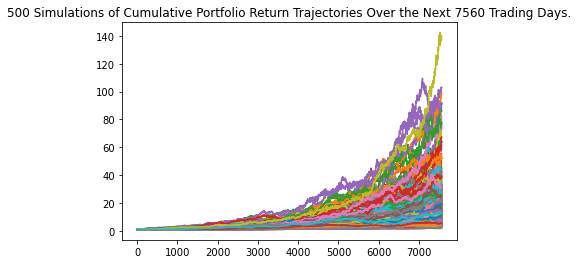

In [23]:
# Plot simulation outcomes
lineplot = MC_retirement.plot_simulation()

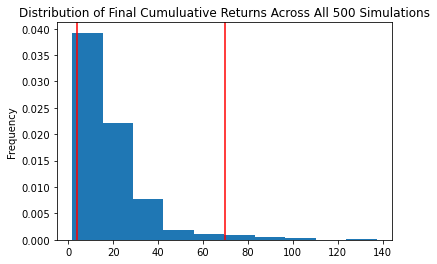

In [24]:
# Plot probability distribution and confidence intervals
distribution = MC_retirement.plot_distribution()

### Retirement Analysis

In [25]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_retirement.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean             19.426095
std              16.360700
min               1.727314
25%               9.524340
50%              14.683091
75%              24.099848
max             137.313052
95% CI Lower      3.779541
95% CI Upper     69.916291
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the 95% lower and upper confidence intervals based on a `$20,000` initial investment.

In [26]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round((tbl['95% CI Lower']* initial_investment),2)
ci_upper = round((tbl['95% CI Upper']* initial_investment),2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $75590.81 and $1398325.82


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [27]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round((tbl['95% CI Lower']* initial_investment),2)
ci_upper = round((tbl['95% CI Upper']* initial_investment),2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $113386.22 and $2097488.73


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [28]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_fiveyear = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40, .60],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [29]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_fiveyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.014526,0.992902,1.011216,0.989870,1.005447,1.003757,1.002033,1.005390,0.999130,0.998939,...,1.000471,1.000865,1.010225,1.012961,0.997011,0.989136,1.001071,1.002305,1.009071,0.997393
2,1.012881,0.998033,1.020336,1.003990,1.008338,0.997734,1.003864,1.006232,1.001216,1.004260,...,1.013311,0.998363,1.010550,1.008636,1.009411,0.987162,0.997110,0.998669,0.993587,0.998493
3,1.013210,1.010261,1.014385,1.002297,1.012307,0.996246,1.009472,1.011577,1.018104,1.018802,...,1.012466,1.004236,1.005125,1.015053,1.007657,0.978302,0.991731,1.007385,1.002972,1.006659
4,1.018774,1.004345,1.017384,0.994813,1.013178,0.999633,0.988711,1.004278,1.026240,1.019470,...,1.018672,1.008718,1.003274,1.009730,0.999532,0.969848,0.977756,1.011276,1.004390,0.997004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.340245,1.520797,1.165280,1.992412,1.424739,1.455929,2.831025,1.085175,1.705367,1.262564,...,3.299755,2.512190,1.416441,0.828592,1.087224,1.162501,1.101986,1.682130,1.607309,2.093192
1257,1.319736,1.528119,1.176574,1.987721,1.426417,1.447468,2.847722,1.095729,1.719016,1.264482,...,3.319571,2.514120,1.433295,0.830381,1.085092,1.166969,1.098263,1.695816,1.597019,2.102792
1258,1.317882,1.556235,1.187219,1.998493,1.423756,1.439181,2.859146,1.084155,1.706467,1.268142,...,3.333053,2.506548,1.441497,0.828270,1.086182,1.173332,1.095048,1.656824,1.584235,2.120781
1259,1.313030,1.551698,1.173763,1.997416,1.440313,1.428207,2.855291,1.085683,1.699626,1.266507,...,3.324610,2.522108,1.441696,0.823082,1.084721,1.166749,1.103997,1.656357,1.604474,2.129845


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

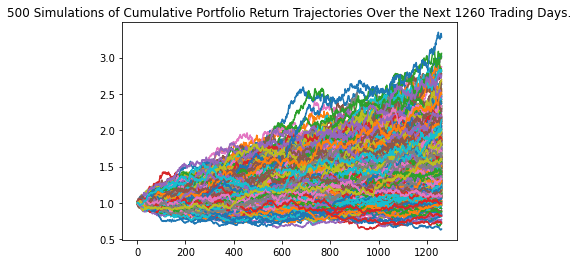

In [30]:
# Plot simulation outcomes
MC_fiveyear.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

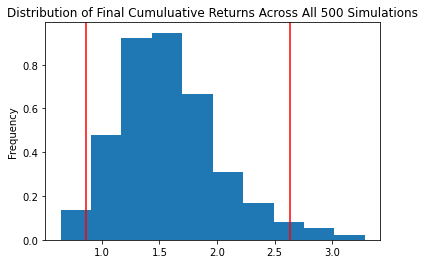

In [31]:
# Plot probability distribution and confidence intervals
MC_fiveyear.plot_distribution()

In [32]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_five = MC_fiveyear.summarize_cumulative_return()
# Print summary statistics
print(tbl_five)

count           500.000000
mean              1.584540
std               0.441660
min               0.641440
25%               1.269238
50%               1.535058
75%               1.835887
max               3.283610
95% CI Lower      0.862454
95% CI Upper      2.635844
Name: 1260, dtype: float64


In [33]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round((tbl_five['95% CI Lower']* initial_investment),2)
ci_upper_five = round((tbl_five['95% CI Upper']* initial_investment),2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 5 years will end within in the range of $17249.09 and $52716.89


### Ten Years Retirement Option

In [34]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_tenyear = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40, .60],
    num_simulation = 500,
    num_trading_days = 252*10
)

In [35]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_tenyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.997418,0.999269,0.985782,1.011313,1.015994,0.999477,0.996340,1.000590,1.004548,0.993325,...,1.002553,0.994694,0.989718,0.995035,1.008668,1.002540,1.001425,1.002162,0.998432,0.999456
2,1.006345,0.999119,0.991174,1.016232,1.010538,1.004523,0.978456,1.009494,1.012975,0.993601,...,0.994327,1.003208,1.000652,0.998055,0.997022,1.004014,1.002076,0.986523,0.990782,0.997948
3,1.004787,0.993996,0.995036,1.010581,1.030506,1.011208,0.967826,1.029681,1.003326,1.002692,...,0.986857,1.014884,1.004799,1.009637,1.000051,0.998242,1.007996,0.994276,0.980823,1.012917
4,1.008567,0.984698,1.003324,0.999264,1.028642,1.018306,0.979748,1.023677,0.997548,0.997623,...,0.988706,1.012474,1.002093,0.995342,1.003346,0.978960,1.000541,0.989728,0.976799,1.009347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.971678,3.494766,2.703790,1.711410,2.436616,2.998019,1.580386,1.654860,2.383662,3.181495,...,2.752678,2.474988,1.206579,3.886699,3.712749,2.538748,2.192256,3.855399,0.826634,2.246299
2517,1.985641,3.500673,2.681620,1.725865,2.442817,2.973879,1.556873,1.650883,2.385571,3.164404,...,2.752897,2.468338,1.221570,3.876041,3.722709,2.567406,2.183642,3.902553,0.832472,2.233792
2518,1.991825,3.492178,2.690613,1.745849,2.424212,2.969865,1.560436,1.671758,2.377942,3.179150,...,2.748662,2.487503,1.236207,3.897343,3.711578,2.594476,2.170540,3.912456,0.839776,2.230592
2519,1.985284,3.529714,2.706319,1.763852,2.413912,2.980564,1.557838,1.670874,2.373404,3.168748,...,2.749030,2.499861,1.225471,3.916890,3.701292,2.575840,2.188086,3.935472,0.842820,2.224048


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

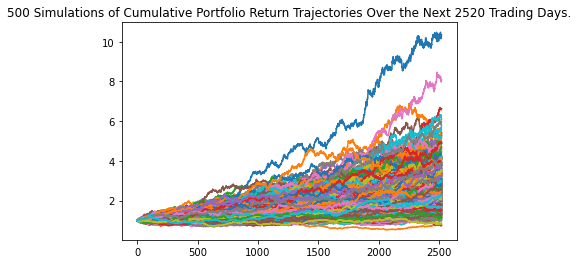

In [36]:
# Plot simulation outcomes
MC_tenyear.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

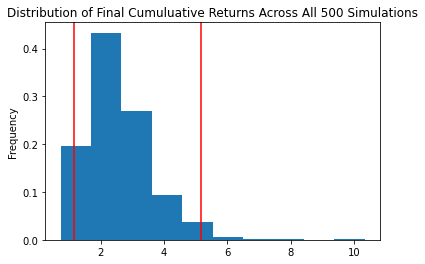

In [37]:
# Plot probability distribution and confidence intervals
MC_tenyear.plot_distribution()

In [38]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_ten = MC_tenyear.summarize_cumulative_return()

# Print summary statistics
print(tbl_ten)

count           500.000000
mean              2.595521
std               1.051806
min               0.736083
25%               1.892371
50%               2.455014
75%               3.077430
max              10.338785
95% CI Lower      1.162497
95% CI Upper      5.176329
Name: 2520, dtype: float64


In [39]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round((tbl_ten['95% CI Lower']* initial_investment),2)
ci_upper_ten = round((tbl_ten['95% CI Upper']* initial_investment),2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 10 years will end within in the range of $23249.94 and $103526.57
